In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import time
from torch.nn import functional as F
from torch.utils.data import DataLoader
import os
import glob
from matplotlib.colors import Normalize
from IPython.display import clear_output

device = torch.device('cpu')

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
class FDTD_Dataset(torch.utils.data.Dataset):
    def __init__(self, src_file, num_rows=None):
        self.src_file = src_file

    def __len__(self):
        main_path = self.src_file
        data_folder_X = os.path.join(main_path, 'X')
        data_filepaths_X = sorted(glob.glob(data_folder_X + "/*"))
        return len(data_filepaths_X)

    def __getitem__(self, idx):
        x_data = X[idx].to(device)
        y_data = y[idx].to(device)

        if torch.is_tensor(idx):
            idx = idx.tolist()

        return x_data, y_data

In [4]:
class SimpleNN(nn.Module):
    def __init__(self, neurons_1, neurons_2, neurons_3, neurons_4):
        super().__init__()
        self.fc1 = nn.Linear(4, neurons_1)
        self.fc2 = nn.Linear(neurons_1, neurons_2)
        self.fc3 = nn.Linear(neurons_2, neurons_3)
        self.fc4 = nn.Linear(neurons_3, neurons_4)
        self.fc5 = nn.Linear(neurons_4, 200)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        return x

In [5]:
def train(num_epochs, model, criterion, optimizer, train_loader, test_loader):
    loss_history = []
    l = []
    val_loss_history = []
    val_l = []
    model.train()
    for epoch in range(0, num_epochs):

        for i, batch in enumerate(train_loader, start=0):
            real_param, real_sp = batch
            pred_sp = model(real_param)
            loss = criterion(real_sp, pred_sp)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            l.append(loss.item())
        last_epoch_loss = torch.tensor(l[-len(train_loader):-1]).mean()
        if epoch % 200 == 0: 
            print("Epoch {} with {:.8f} loss".format(epoch, last_epoch_loss))
        loss_history.append(last_epoch_loss)

        for j, val_batch in enumerate(test_loader, start=0):
            val_real_param, val_real_sp = val_batch
            val_pred_sp = model(val_real_param)
            val_loss = criterion(val_real_sp, val_pred_sp)
            val_l.append(val_loss.item())
        val_last_epoch_loss = torch.tensor(val_l[-len(test_loader):-1]).mean()
        val_loss_history.append(val_last_epoch_loss)

    return l, last_epoch_loss, loss_history, val_loss_history

In [6]:
### DATASET PREPROCESSING ######

main_path = './precise_data'
data_folder_X = os.path.join(main_path, 'X')
data_folder_Y = os.path.join(main_path, 'Y')
data_filepaths_X = sorted(glob.glob(data_folder_X + "/*"))
data_filepaths_Y = sorted(glob.glob(data_folder_Y + "/*"))

X = np.array(pd.read_csv(data_filepaths_X[0], sep=": ",
                         names=['parameter', 'value'])['value'])
Y = np.array(pd.read_csv(data_filepaths_Y[0], sep="\t",
                         names=['wavelength', 'LCP', 'RCP', 'CD'])['CD'])

for path in data_filepaths_X[1:2]:
    x_tmp = np.array(pd.read_csv(path, sep=": ",
                     names=['parameter', 'value'])['value'])
    X = np.stack((X, x_tmp), axis=0)

for path in data_filepaths_Y[1:2]:
    y_tmp = np.array(pd.read_csv(path, sep="\t",
                     names=['wavelength', 'LCP', 'RCP', 'CD'])['CD'])
    Y = np.stack((Y, y_tmp), axis=0)

for path in data_filepaths_X[2:]:
    x_tmp = np.array(pd.read_csv(path, sep=": ",
                     names=['parameter', 'value'])['value'])
    X = np.append(arr=X, values=np.array([x_tmp]), axis=0)

for path in data_filepaths_Y[2:]:
    y_tmp = np.array(pd.read_csv(path, sep="\t", 
                     names=['wavelength', 'LCP', 'RCP', 'CD'])['CD'])
    Y = np.append(arr=Y, values=np.array([y_tmp]), axis=0)

X = np.delete(X, (1, 2, 3, 4), 1)

X = torch.from_numpy(X).float()
y = torch.from_numpy(Y).float()

mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

dataset = FDTD_Dataset(src_file=main_path)
training_data, test_data = torch.utils.data.random_split(dataset, [338, 37])

y_tmp = pd.read_csv(data_filepaths_Y[0], sep="\t",
                    names=['wavelength', 'LCP', 'RCP', 'CD'])
wavelengths = y_tmp['wavelength']

clear_output(wait=False)

In [7]:
#### TRAINING THE MODEL ##############

start = time.time()
model = SimpleNN(32, 64, 128, 256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

epochs = 3000
train_loader = DataLoader(training_data, num_workers=0, batch_size=16,
                          shuffle=True)
test_loader = DataLoader(test_data, num_workers=0, batch_size=1,
                         shuffle=True)  
l_optim, _, loss_history, val_loss_history = train(epochs, model, criterion,
                                                   optimizer, train_loader,
                                                   test_loader)  
end = time.time()

Epoch 0 with 0.00285634 loss
Epoch 200 with 0.00012372 loss
Epoch 400 with 0.00005873 loss
Epoch 600 with 0.00004049 loss
Epoch 800 with 0.00003089 loss
Epoch 1000 with 0.00002496 loss
Epoch 1200 with 0.00002054 loss
Epoch 1400 with 0.00001739 loss
Epoch 1600 with 0.00001498 loss
Epoch 1800 with 0.00001296 loss
Epoch 2000 with 0.00001132 loss
Epoch 2200 with 0.00000995 loss
Epoch 2400 with 0.00000879 loss
Epoch 2600 with 0.00000785 loss
Epoch 2800 with 0.00000704 loss


In [8]:
print("Model training time: " + str(end - start) + " seconds")

Model training time: 100.8368124961853 seconds


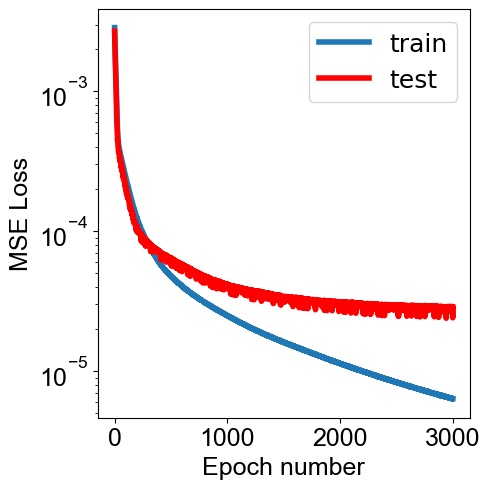

In [9]:
fig = plt.figure(figsize=(5, 5))
font = {'fontname': 'Arial', 'size': 22}
plt.rcParams.update({'font.serif': 'Times'})
plt.plot(loss_history, label="train", linewidth=4)
plt.plot(val_loss_history, label="test", linewidth=4, color='red')
plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')
plt.yscale('log')
font = {'fontname': 'Arial', 'size': 18}
plt.xlabel('Epoch number', **font)
plt.ylabel('MSE Loss', **font)
plt.xticks(ticks=range(0, 3001, 1000), **font)
plt.yticks(**font)
plt.legend(fontsize=18)
axes = plt.gca()
plt.tight_layout()
plt.savefig('train_curv.png', format='png', bbox_inches='tight')
plt.show()

In [10]:
def plot_predictions(model, test_loader):
    predictions = []
    losses = []
    model.eval()

    for i, batch in enumerate(test_loader, 0):

        real_param, real_sp = batch
        print(real_param)
        pred_sp = model(real_param)
        loss = criterion(real_sp, pred_sp)
        predictions.append(pred_sp)
        losses.append(loss)
        
        fig = plt.figure(figsize=(5, 5))
        font = {'fontname': 'Arial', 'size': 22}
        plt.rcParams.update({'font.serif': 'Times'})
        plt.plot(wavelengths * 1e9, pred_sp.detach().numpy()[0],
                 label='ANN', color='darkblue')
        plt.plot(wavelengths * 1e9, real_sp.detach().numpy()[0],
                 label='FDTD', linestyle='dotted', color='green',
                 linewidth=2)
        font = {'fontname': 'Arial', 'size': 18}
        plt.xlabel('Wavelength, nm', **font)
        plt.ylabel('CD', **font)
        plt.xticks(**font)
        plt.yticks(**font)
        plt.xlim([500, 1000])
        plt.legend(fontsize=18)
        axes = plt.gca()
        plt.tight_layout()
        plt.show()
        print((real_param * std + mean) * 1e9)

    return predictions, losses

tensor([[-1.2231e+00,  4.0141e-06,  1.4123e+00, -1.4123e+00]])


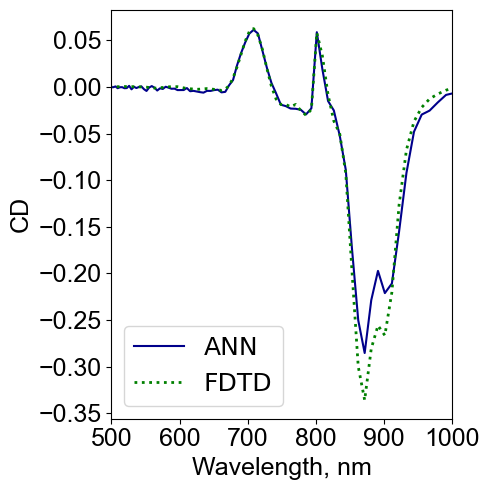

tensor([[450., 300.,  80.,  20.]])
tensor([[ 1.2231, -1.4123,  1.4123,  1.4123]])


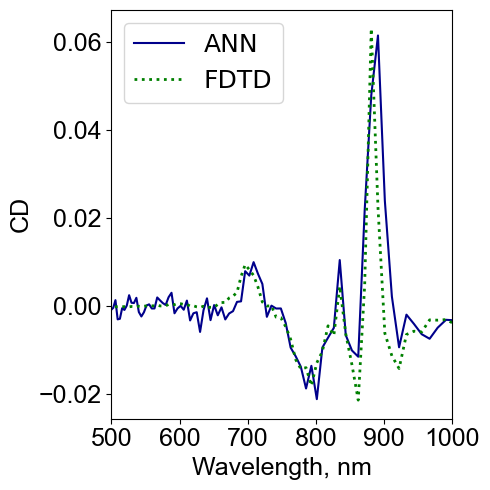

tensor([[470.0000, 280.0000,  80.0000,  60.0000]])
tensor([[-1.2231e+00,  4.0141e-06, -1.4123e+00, -1.4123e+00]])


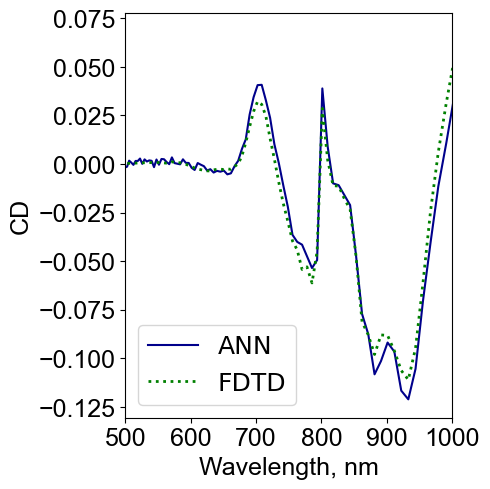

tensor([[450., 300.,  40.,  20.]])
tensor([[1.2231e+00, 1.4123e+00, 7.0616e-01, 2.5088e-07]])


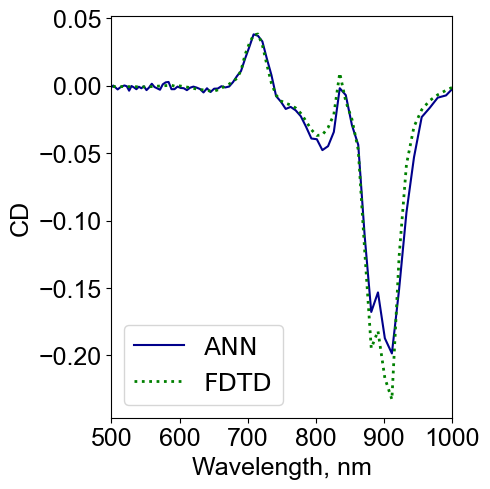

tensor([[470., 320.,  70.,  40.]])
tensor([[-1.2231, -1.4123,  1.4123, -1.4123]])


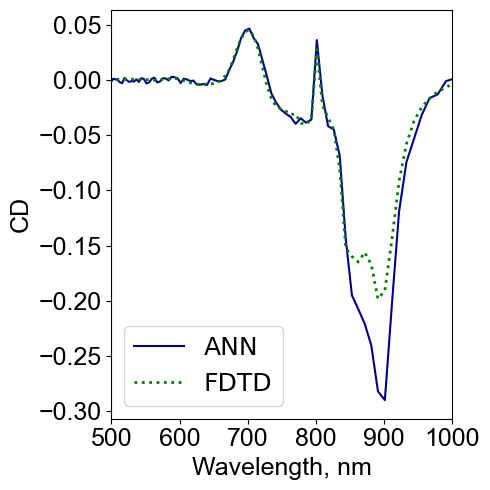

tensor([[450., 280.,  80.,  20.]])
tensor([[1.2231, 1.4123, 0.0000, 1.4123]])


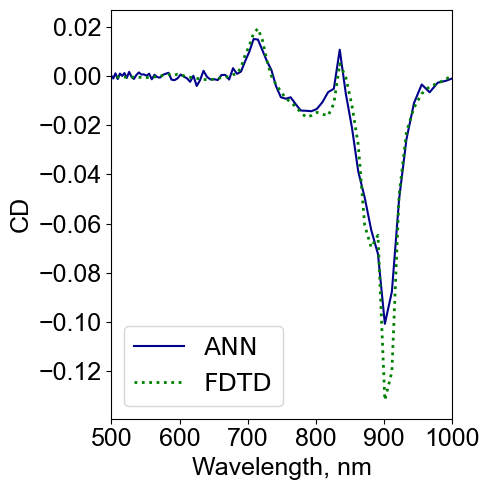

tensor([[470.0000, 320.0000,  60.0000,  60.0000]])
tensor([[-1.2231, -0.7062, -0.7062,  0.7062]])


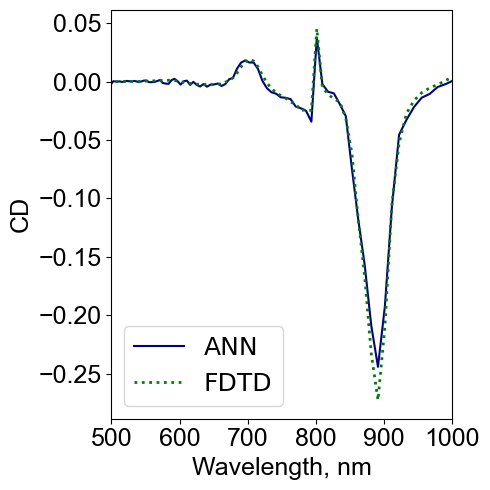

tensor([[450., 290.,  50.,  50.]])
tensor([[-1.2231, -0.7062,  0.7062, -0.7062]])


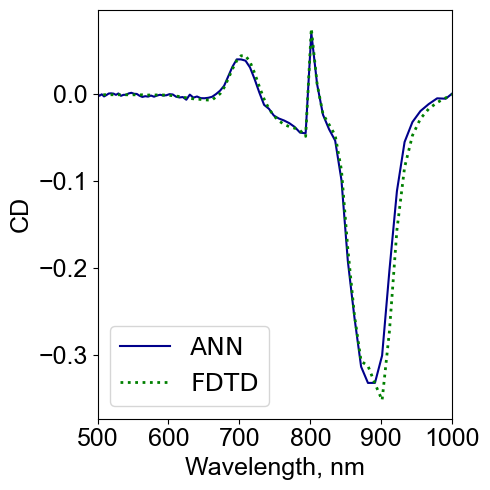

tensor([[450.0000, 290.0000,  70.0000,  30.0000]])
tensor([[ 1.2231e+00, -1.4123e+00,  0.0000e+00,  2.5088e-07]])


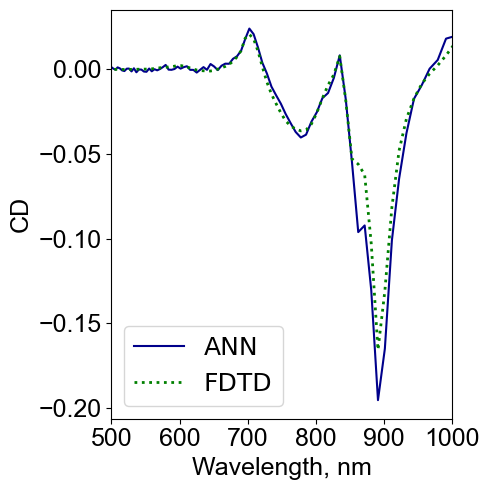

tensor([[470.0000, 280.0000,  60.0000,  40.0000]])
tensor([[-1.2231, -0.7062, -1.4123,  0.7062]])


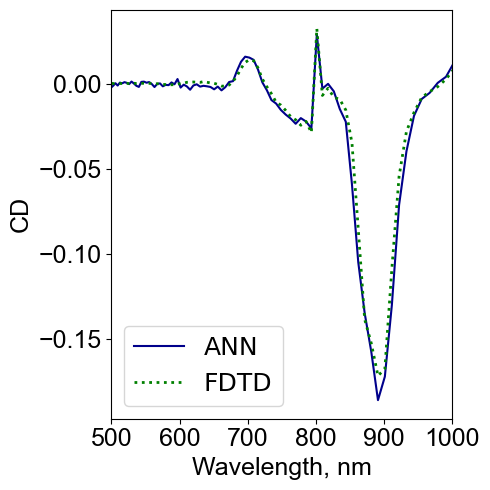

tensor([[450., 290.,  40.,  50.]])
tensor([[3.4763e-06, 4.0141e-06, 7.0616e-01, 1.4123e+00]])


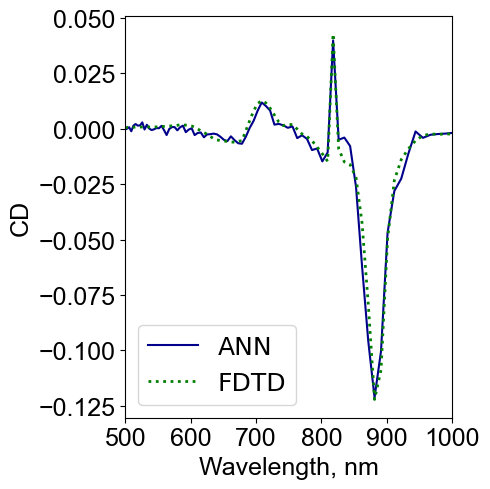

tensor([[460.0000, 300.0000,  70.0000,  60.0000]])
tensor([[ 3.4763e-06,  7.0617e-01, -7.0616e-01, -1.4123e+00]])


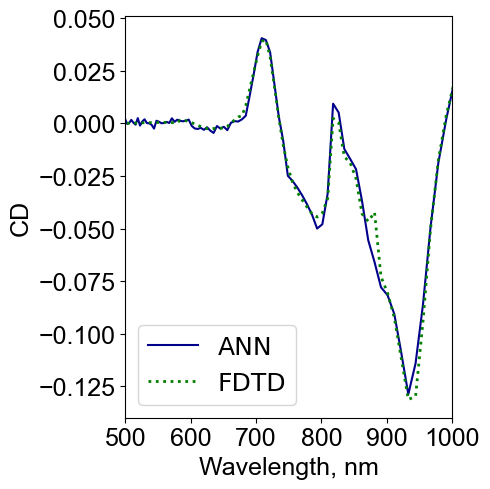

tensor([[460., 310.,  50.,  20.]])
tensor([[ 1.2231e+00,  4.0141e-06, -7.0616e-01,  2.5088e-07]])


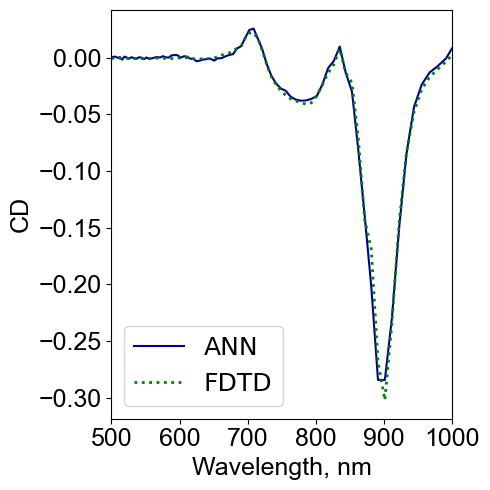

tensor([[470., 300.,  50.,  40.]])
tensor([[ 1.2231, -0.7062, -1.4123, -1.4123]])


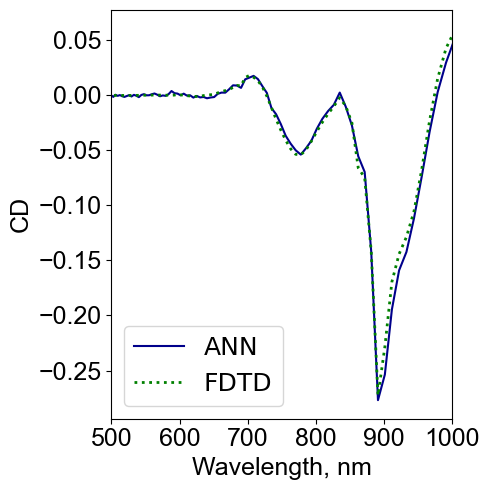

tensor([[470., 290.,  40.,  20.]])
tensor([[-1.2231, -1.4123,  0.0000, -0.7062]])


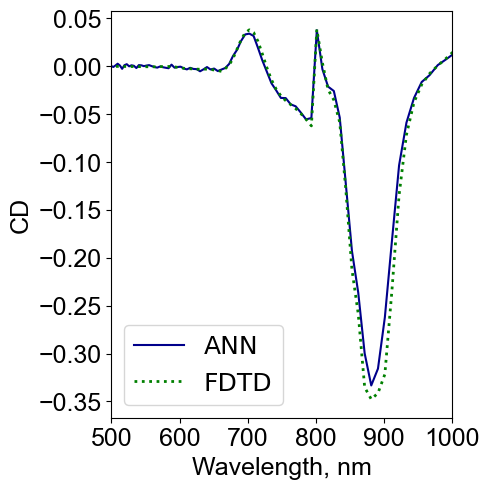

tensor([[450.0000, 280.0000,  60.0000,  30.0000]])
tensor([[-1.2231, -1.4123, -1.4123,  0.7062]])


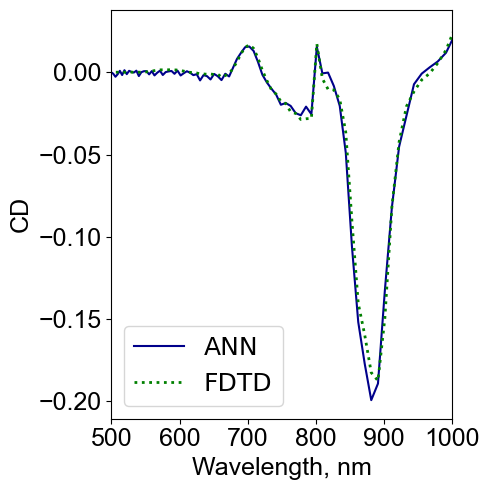

tensor([[450., 280.,  40.,  50.]])
tensor([[1.2231e+00, 4.0141e-06, 1.4123e+00, 2.5088e-07]])


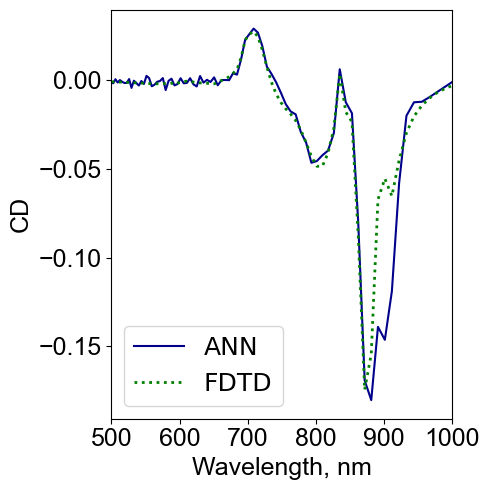

tensor([[470., 300.,  80.,  40.]])
tensor([[ 1.2231, -0.7062, -0.7062,  1.4123]])


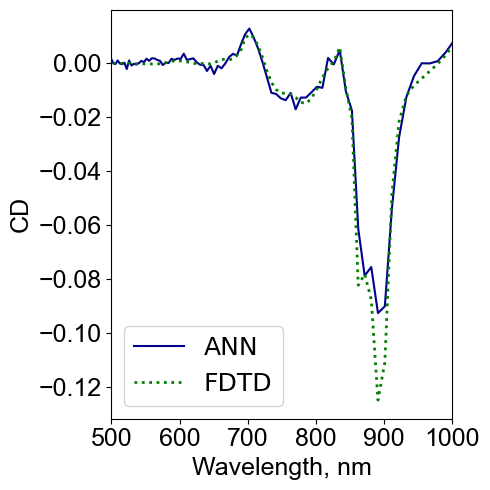

tensor([[470.0000, 290.0000,  50.0000,  60.0000]])
tensor([[1.2231, 1.4123, 0.7062, 1.4123]])


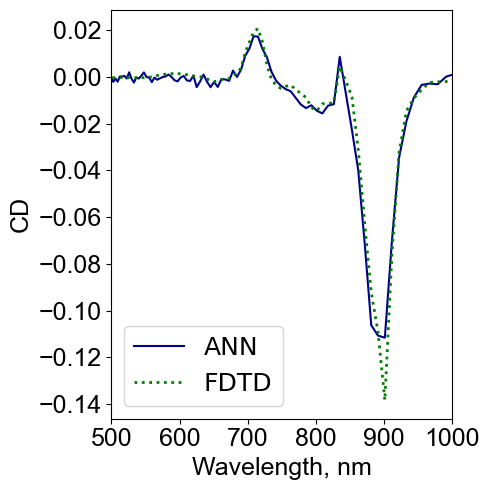

tensor([[470.0000, 320.0000,  70.0000,  60.0000]])
tensor([[-1.2231,  1.4123, -1.4123,  0.7062]])


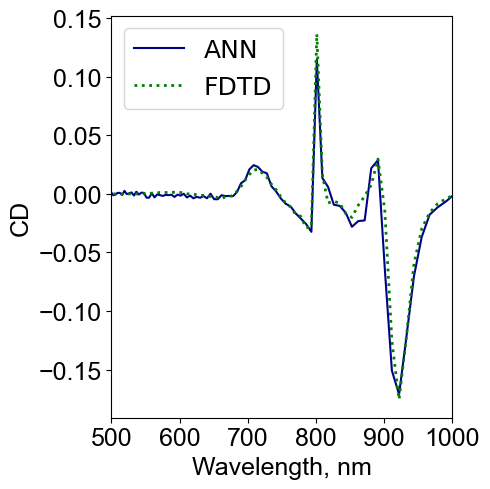

tensor([[450., 320.,  40.,  50.]])
tensor([[ 3.4763e-06, -1.4123e+00, -7.0616e-01,  7.0616e-01]])


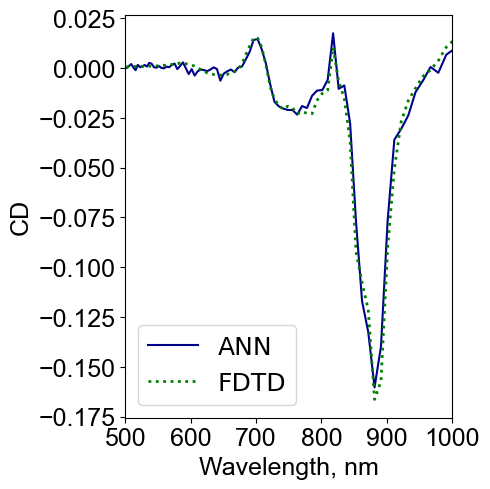

tensor([[460., 280.,  50.,  50.]])
tensor([[ 3.4763e-06, -7.0616e-01, -7.0616e-01,  1.4123e+00]])


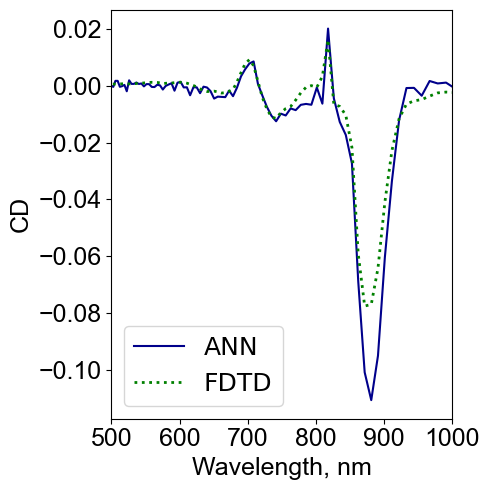

tensor([[460.0000, 290.0000,  50.0000,  60.0000]])
tensor([[3.4763e-06, 1.4123e+00, 7.0616e-01, 2.5088e-07]])


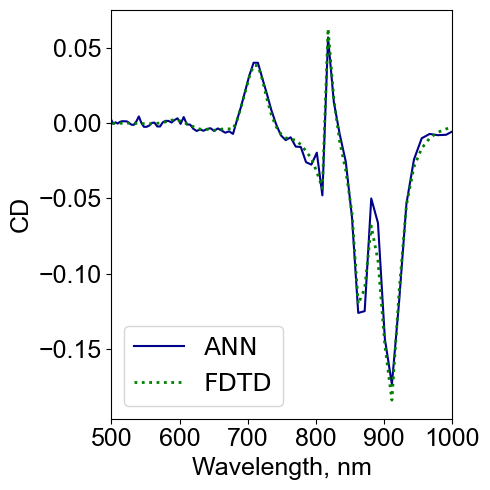

tensor([[460., 320.,  70.,  40.]])
tensor([[-1.2231,  0.7062,  1.4123,  1.4123]])


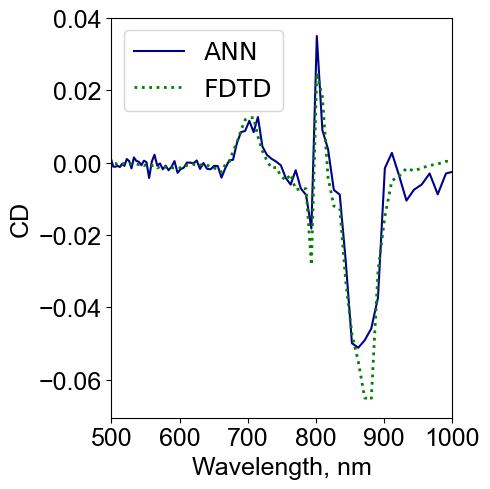

tensor([[450.0000, 310.0000,  80.0000,  60.0000]])
tensor([[-1.2231,  0.7062, -0.7062, -0.7062]])


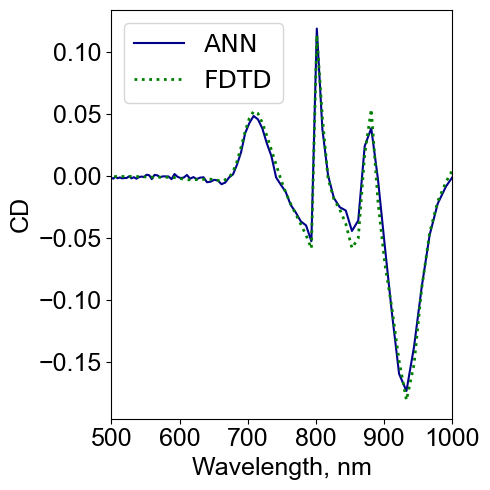

tensor([[450.0000, 310.0000,  50.0000,  30.0000]])
tensor([[-1.2231, -1.4123,  1.4123,  1.4123]])


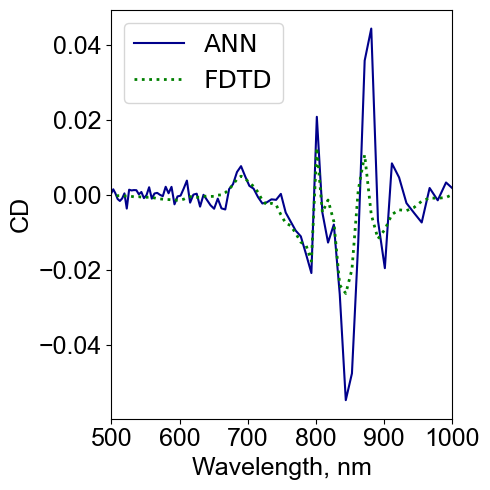

tensor([[450.0000, 280.0000,  80.0000,  60.0000]])
tensor([[-1.2231e+00,  4.0141e-06,  0.0000e+00, -7.0616e-01]])


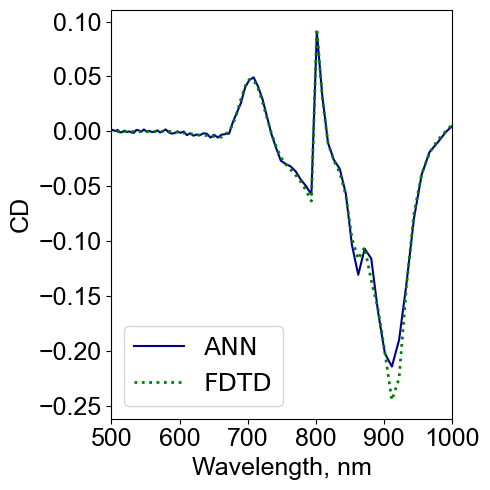

tensor([[450.0000, 300.0000,  60.0000,  30.0000]])
tensor([[ 3.4763e-06, -1.4123e+00, -1.4123e+00,  7.0616e-01]])


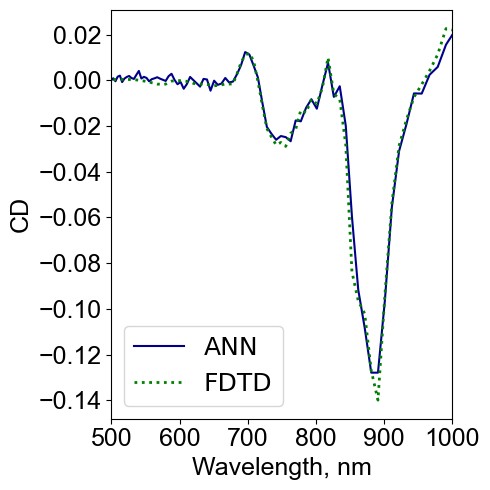

tensor([[460., 280.,  40.,  50.]])
tensor([[ 3.4763e-06,  7.0617e-01, -7.0616e-01,  1.4123e+00]])


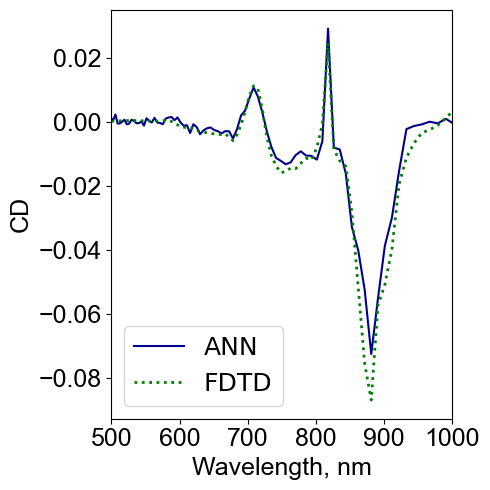

tensor([[460.0000, 310.0000,  50.0000,  60.0000]])
tensor([[ 3.4763e-06, -7.0616e-01,  1.4123e+00, -1.4123e+00]])


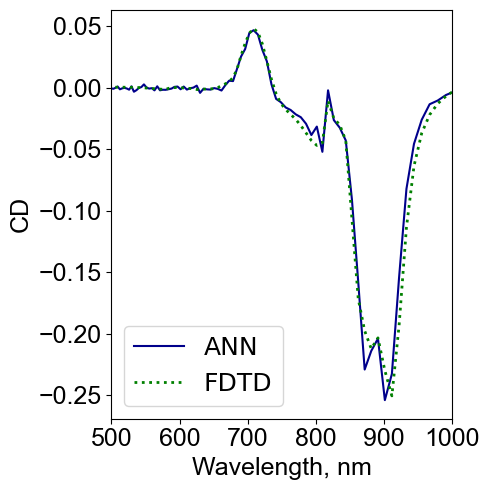

tensor([[460., 290.,  80.,  20.]])
tensor([[-1.2231,  1.4123, -0.7062, -0.7062]])


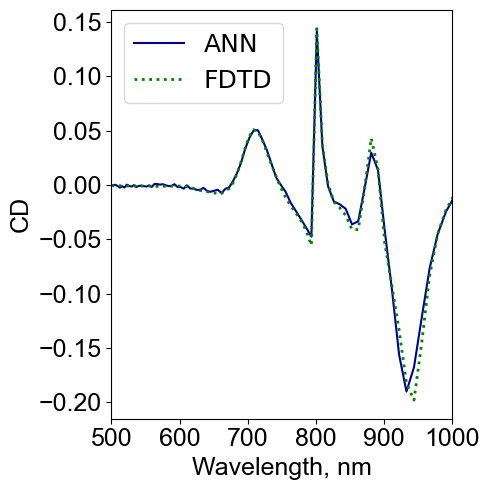

tensor([[450.0000, 320.0000,  50.0000,  30.0000]])
tensor([[ 3.4763e-06,  4.0141e-06, -7.0616e-01,  1.4123e+00]])


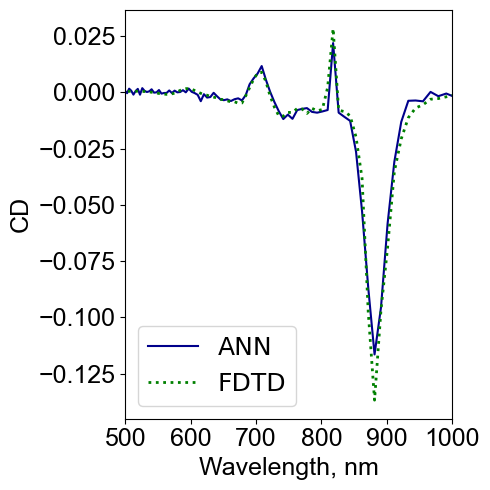

tensor([[460.0000, 300.0000,  50.0000,  60.0000]])
tensor([[ 3.4763e-06, -1.4123e+00, -1.4123e+00,  2.5088e-07]])


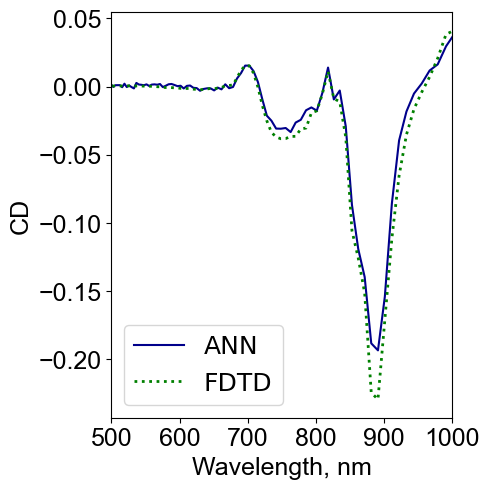

tensor([[460., 280.,  40.,  40.]])
tensor([[1.2231, 1.4123, 0.7062, 0.7062]])


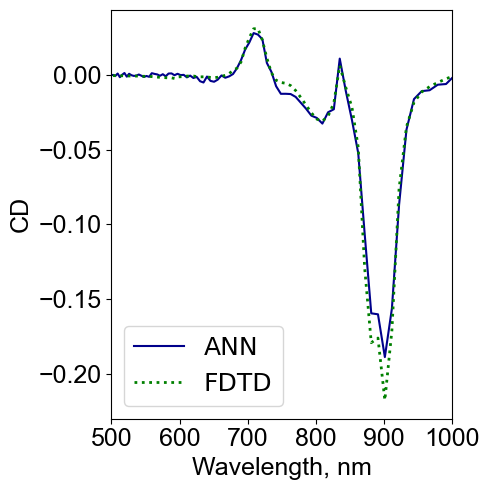

tensor([[470., 320.,  70.,  50.]])
tensor([[3.4763e-06, 7.0617e-01, 1.4123e+00, 1.4123e+00]])


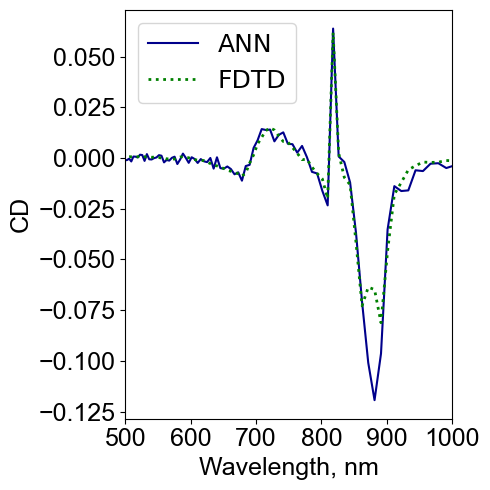

tensor([[460.0000, 310.0000,  80.0000,  60.0000]])
tensor([[ 1.2231,  1.4123, -0.7062,  0.7062]])


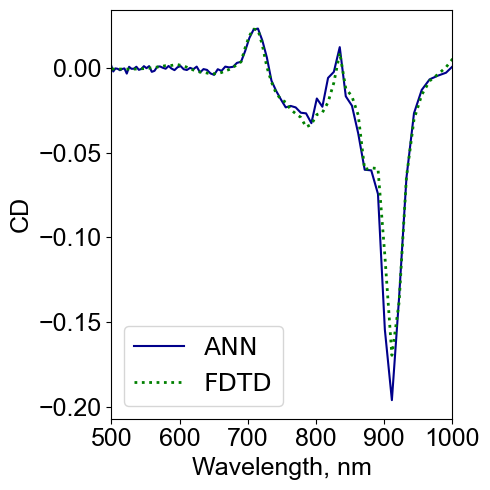

tensor([[470., 320.,  50.,  50.]])
tensor([[-1.2231,  0.7062,  1.4123, -1.4123]])


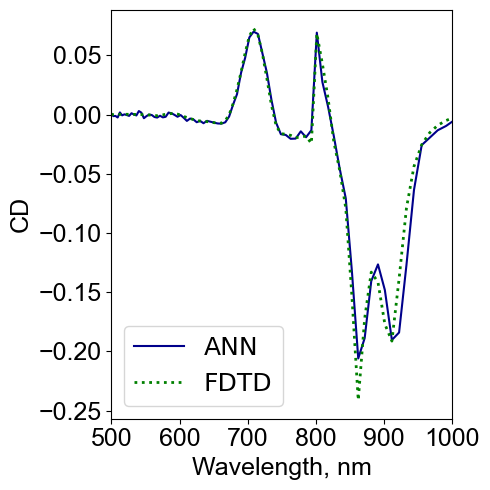

tensor([[450., 310.,  80.,  20.]])


In [11]:
predictions, losses = plot_predictions(model, test_loader)

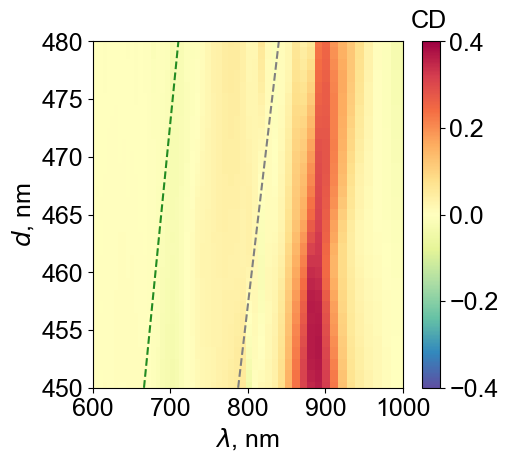

In [12]:
period = 0.46e-6
b = 0.285e-6
bias = 0.055e-6
gap = 0.035e-6

period_range = np.arange(0.45e-6, 0.481e-6, step=0.001e-6)

column_names = wavelengths.tolist()
df = pd.DataFrame(columns=column_names)
for period in period_range:
    x = np.array([period, b, bias, gap])
    x = torch.from_numpy(x).float()
    x = (x - mean) / std
    x = torch.unsqueeze(x, dim=0)
    cd_sp = model(x.to(device))
    df.loc[period] = cd_sp[0, :].detach().numpy()
font = {'fontname': 'Arial', 'size': 18}
fig = plt.figure(figsize=(5, 4.5))
y = period_range * 1e9
x = wavelengths * 1e9
plt.pcolormesh(x, y, -df.astype(float), cmap='Spectral_r',
               norm=Normalize(vmin=-0.4, vmax=0.4, clip=False),
               shading='auto')
plt.plot(y * 1.75, y, linestyle='dashed', color='grey')
plt.plot(y * 1.48, y, linestyle='dashed', color='forestgreen')
plt.xticks(**font)
plt.yticks(ticks=range(450, 481, 5), **font)
plt.xlim([600, 1000])
plt.ylim([450, 480])
cbar = plt.colorbar()
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family("Arial")
cbar.ax.tick_params(labelsize=18)
plt.ylabel(r'$d$, nm', **font)
plt.xlabel(r'$\lambda$, nm', **font)

fig.text(0.76, 0.91, 'СD', **font)
plt.savefig('pred_d.png', format='png', bbox_inches='tight')

In [13]:
def best_cd(cd_sp):
    pos_sp = max(max(cd_sp))
    neg_sp = min(min(cd_sp))
    if abs(pos_sp) > abs(neg_sp):
        return pos_sp
    else:
        return neg_sp

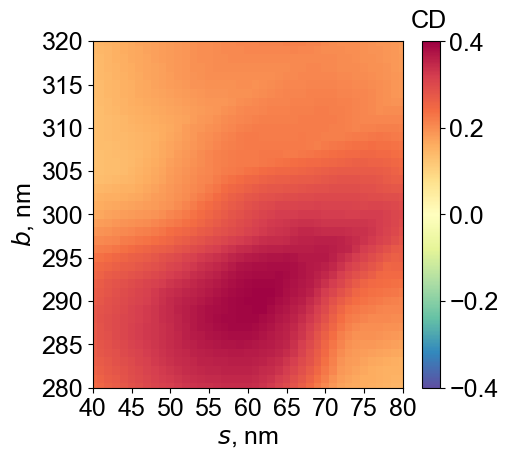

In [14]:
period = 0.455e-6
b = 0.285e-6
bias = 0.055e-6
gap = 0.035e-6

bias_range = np.arange(0.04e-6, 0.081e-6, step=0.001e-6)
b_range = np.arange(0.28e-6, 0.321e-6, step=0.001e-6)

column_names = bias_range.tolist()
column_names.append(0.)
df = pd.DataFrame(columns=column_names)
df[0.] = pd.Series(data=b_range)
for bias in bias_range:
    for b in b_range:
        x = np.array([period, b, bias, gap])
        x = torch.from_numpy(x).float()
        x = (x - mean) / std
        x = torch.unsqueeze(x, dim=0)
        cd_sp = model(x.to(device))
        df.loc[df[0.] == b, bias] = best_cd(cd_sp).item()

font = {'fontname': 'Arial', 'size': 18}
fig = plt.figure(figsize=(5, 4.5))
x = bias_range * 1e9
y = b_range * 1e9
plt.pcolormesh(x, y, -df.iloc[:, 0:-1].astype(float), cmap='Spectral_r',
               norm=Normalize(vmin=-0.4, vmax=0.4, clip=False),
               shading='auto')
plt.xticks(**font)
plt.yticks(**font)
plt.yticks(ticks=range(280, 321, 5), **font)
plt.xticks(ticks=range(40, 81, 5), **font)
plt.xlim([40, 80])
plt.ylim([280, 320])
cbar = plt.colorbar()
plt.ylabel(r'$b$, nm', **font)
plt.xlabel(r'$s$, nm', **font)
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family("Arial")
cbar.ax.tick_params(labelsize=18)
fig.text(0.76, 0.91, 'СD', **font)
plt.savefig('pred_b.png', format='png', bbox_inches='tight')

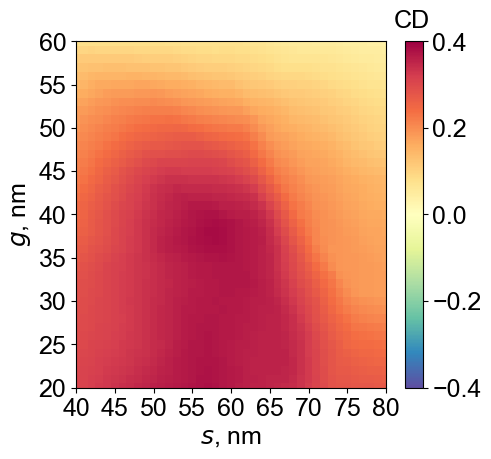

In [15]:
period = 0.455e-6
b = 0.285e-6
bias = 0.055e-6
gap = 0.035e-6

bias_range = np.arange(0.04e-6, 0.081e-6, step=0.001e-6)
gap_range = np.arange(0.02e-6, 0.061e-6, step=0.001e-6)

column_names = bias_range.tolist()
column_names.append(0.)
df = pd.DataFrame(columns=column_names)
df[0.] = pd.Series(data=gap_range)
for bias in bias_range:
    for gap in gap_range:
        x = np.array([period, b, bias, gap])
        x = torch.from_numpy(x).float()
        x = (x - mean) / std
        x = torch.unsqueeze(x, dim=0)
        cd_sp = model(x.to(device))
        df.loc[df[0.] == gap, bias] = best_cd(cd_sp).item()
font = {'fontname': 'Arial', 'size': 18}
fig = plt.figure(figsize=(5, 4.5))
x = bias_range * 1e9
y = gap_range * 1e9
plt.pcolormesh(x, y, -df.iloc[:, 0:-1].astype(float), cmap='Spectral_r',
               norm=Normalize(vmin=-0.4, vmax=0.4, clip=False),
               shading='auto')
cbar = plt.colorbar()
plt.ylabel(r'$g$, nm', **font)
plt.xlabel(r'$s$, nm', **font)
plt.xticks(ticks=range(40, 81, 5), **font)
plt.xlim([40, 80])
plt.ylim([20, 60])
plt.xticks(**font)
plt.yticks(**font)
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family("Arial")
cbar.ax.tick_params(labelsize=18)
fig.text(0.76, 0.91, 'СD', **font)
plt.savefig('pred_g.png', format='png', bbox_inches='tight')

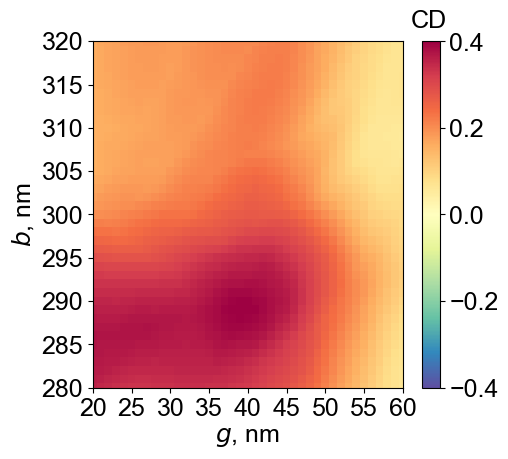

In [16]:
period = 0.455e-6
b = 0.285e-6
bias = 0.055e-6
gap = 0.035e-6

gap_range = np.arange(0.02e-6, 0.061e-6, step=0.001e-6)
b_range = np.arange(0.28e-6, 0.321e-6, step=0.001e-6)

column_names = gap_range.tolist()
column_names.append(0.)
df = pd.DataFrame(columns=column_names)
df[0.] = pd.Series(data=b_range)
for gap in gap_range:
    for b in b_range:
        x = np.array([period, b, bias, gap])
        x = torch.from_numpy(x).float()
        x = (x - mean) / std
        x = torch.unsqueeze(x, dim=0)
        cd_sp = model(x.to(device))
        df.loc[df[0.] == b, gap] = best_cd(cd_sp).item()
font = {'fontname': 'Arial', 'size': 18}
fig = plt.figure(figsize=(5, 4.5))
x = gap_range * 1e9
y = b_range * 1e9
plt.pcolormesh(x, y, -df.iloc[:, 0:-1].astype(float), cmap='Spectral_r',
               norm=Normalize(vmin=-0.4, vmax=0.4, clip=False),
               shading='auto')
plt.xticks(**font)
plt.yticks(**font)
plt.xticks(ticks=range(20, 61, 5), **font)
plt.xlim([20, 60])
plt.ylim([280, 320])
cbar = plt.colorbar()
for t in cbar.ax.yaxis.get_ticklabels():
    t.set_family("Arial")
cbar.ax.tick_params(labelsize=18)
plt.ylabel(r'$b$, nm', **font)
plt.xlabel(r'$g$, nm', **font)
fig.text(0.76, 0.91, 'СD', **font)
plt.savefig('pred_b2.png', format='png', bbox_inches='tight')